In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random


In [42]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [43]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1438  0.657754  0.576716  0.292458  0.150638  0.440545  0.069131  0.194465   
1917  0.245989  0.911339  0.738492  0.213652  0.734908  0.422760  0.322666   
800   0.123251  0.906629  0.834672  0.214894  0.816231  0.555525  0.394767   
1929  0.214332  0.912853  0.733790  0.217376  0.757692  0.412314  0.314571   
642   0.145433  0.895357  0.910088  0.325355  0.837851  0.696262  0.946348   
...        ...       ...       ...       ...       ...       ...       ...   
1029  0.131337  0.941790  0.927718  0.344149  0.985032  0.741891  0.943712   
353   0.713155  0.806023  0.653477  0.187943  0.571761  0.315283  0.233057   
1624  0.431444  0.570323  0.331440  0.191489  0.509230  0.065778  0.240776   
248   0.113840  0.918742  0.916748  0.993085  0.985032  0.769379  0.959902   
91    0.203936  0.951884  0.866797  0.959397  0.974389  0.588785  0.971762   

            F9        F5      F7       F12       F8  
1438  0.0

# RFE implement

In [44]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR


estimator = SVR(kernel="linear")
model = RFE(estimator, n_features_to_select=3, step=1)
model.fit(dataset,label)



RFE(estimator=SVR(kernel='linear'), n_features_to_select=3)

In [45]:

compressed_dataset_X= model.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

<class 'numpy.ndarray'>
3
[[0.29245837 0.1506383  0.08467683]
 [0.73849167 0.21365248 0.2030138 ]
 [0.83467189 0.21489362 0.32312999]
 ...
 [0.33143976 0.19148936 0.10548293]
 [0.91674829 0.99308511 0.57697894]
 [0.86679726 0.95939716 0.83805374]]


In [46]:
dataset_arr=dataset.to_numpy()


In [47]:
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [48]:
compressed_dataset_X_train= model.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= model.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[0.29245837 0.20301418 0.0953159 ]
 [0.89363369 0.23510638 0.44989107]
 [0.85994123 0.1964539  0.25708061]
 ...
 [0.35063663 0.19804965 0.09974582]
 [0.81449559 0.21187943 0.21764706]
 [0.36591577 0.20602837 0.07799564]]
<class 'numpy.ndarray'>
664
[[0.84544564 0.23244681 0.41430646]
 [0.28854065 0.18421986 0.116122  ]
 [0.36160627 0.19308511 0.08511256]
 ...
 [0.78374143 0.47925532 0.26993464]
 [0.9036239  0.28758865 0.42193174]
 [0.71714006 0.2285461  0.16488744]]


# tune with SVC

In [49]:
# train the model with random parameter
from sklearn.svm import SVC

model_SVC = SVC(
        C=8.75,#Regularization parameter
        kernel="rbf", # maximum number of estimators at which boosting is terminated
        gamma=0.4,
        tol=0.483,
        decision_function_shape='ovo',
        
     )

model_SVC.fit(compressed_dataset_X_train, y_train)

SVC(C=8.75, decision_function_shape='ovo', gamma=0.4, tol=0.483)

In [50]:
# Finding mean absolute error
preds = model_SVC.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.20180722891566266

In [51]:
# Defining the best parameter with optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(compressed_dataset_X)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_SVC(trial):

 for train_index, val_index in (skf.split(compressed_dataset_X,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        
    param = {
        'C':trial.suggest_float("C",0,10), #For regularization    
        'kernel':trial.suggest_categorical('kernel',["linear", "poly", "rbf", "sigmoid"]),
        'degree':trial.suggest_int('degree',1,10),
        'gamma':trial.suggest_float('gamma',0,1),
        # 'tol':trial.suggest_float('tol',0,5),
        # 'coef0':trial.suggest_float('coed0',0,3),
        'decision_function_shape':trial.suggest_categorical('decision_function_shape',['ovo','ovr']),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model= SVC(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X

      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [52]:
# this is the main optuna for optimizing a object-->"objective"
study_SVC = optuna.create_study(direction='minimize',study_name="SVC_tunning")

[I 2024-02-12 08:49:55,310] A new study created in memory with name: SVC_tunning


In [53]:

study_SVC.optimize(objective_SVC, n_trials=15) 
print('Number of finished trials:', len(study_SVC.trials))
print('Best trial:', study_SVC.best_trial.params)

[I 2024-02-12 08:49:55,666] Trial 0 finished with value: 0.26717902350813744 and parameters: {'C': 5.407544273516873, 'kernel': 'poly', 'degree': 8, 'gamma': 0.6644847097673279, 'decision_function_shape': 'ovo', 'random_state': 0}. Best is trial 0 with value: 0.26717902350813744.
[I 2024-02-12 08:49:56,010] Trial 1 finished with value: 0.19122965641952983 and parameters: {'C': 1.5307271528720157, 'kernel': 'rbf', 'degree': 9, 'gamma': 0.7857151315262375, 'decision_function_shape': 'ovr', 'random_state': 3}. Best is trial 1 with value: 0.19122965641952983.
[I 2024-02-12 08:49:56,320] Trial 2 finished with value: 0.5922242314647378 and parameters: {'C': 9.8410514280358, 'kernel': 'sigmoid', 'degree': 10, 'gamma': 0.879766618850866, 'decision_function_shape': 'ovr', 'random_state': 5}. Best is trial 1 with value: 0.19122965641952983.
[I 2024-02-12 08:49:56,714] Trial 3 finished with value: 0.7825497287522604 and parameters: {'C': 2.736318380094218, 'kernel': 'poly', 'degree': 10, 'gamma':

Number of finished trials: 15
Best trial: {'C': 7.8196670866093, 'kernel': 'rbf', 'degree': 6, 'gamma': 0.9428589643464683, 'decision_function_shape': 'ovr', 'random_state': 5}


In [54]:
#evaluate the trial
print("Number of finished trials: ", len(study_SVC.trials))
print("Best trial:")
trial = study_SVC.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  15
Best trial:
  Value:  0.16636528028933092
  Params: 
    C: 7.8196670866093
    kernel: rbf
    degree: 6
    gamma: 0.9428589643464683
    decision_function_shape: ovr
    random_state: 5


# fit the SVM model

In [55]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_SVC = np.array(compressed_dataset_X_train)
target_train_SVC = np.array(y_train)

test_SVC = np.array(compressed_dataset_X_test) # or test_Ada = np.array(X)


test_preds_SVC = np.zeros((len(test_SVC)))
oof_preds_SVC = np.zeros((len(train_SVC)))

for train_index, val_index in tqdm(skf.split(compressed_dataset_X_train,y_train), total=5):
    train_X, valid_X = train_SVC[train_index], train_SVC[val_index]
    train_y, valid_y = target_train_SVC[train_index], target_train_SVC[val_index]
    svc_params = study_SVC.best_trial.params
    model_SVC_2 = SVC(**svc_params)
    model_SVC_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_SVC_2.predict(valid_X)
    oof_preds_SVC[val_index] = preds
    # for test accuracy
    preds = model_SVC_2.predict(test_SVC)
    test_preds_SVC += (preds)/5
print(np.abs(oof_preds_SVC-target_train_SVC).mean())

100%|██████████| 5/5 [00:00<00:00, 15.93it/s]

0.17118863049095606


In [56]:
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds_SVC.round())
print(test_Acc_SVC)

0.8493975903614458


In [57]:
#validation accuracy
valid_Acc=accuracy_score(target_train_SVC,oof_preds_SVC)
print(valid_Acc)

0.8572351421188631


In [58]:
# train accuracy
train_Acc=model_SVC_2.score(compressed_dataset_X_train,y_train)
print(train_Acc)

0.8604651162790697


In [59]:
# test_accuracy
test_Acc=model_SVC_2.score(compressed_dataset_X_test,y_test)
print(test_Acc)

0.8539156626506024


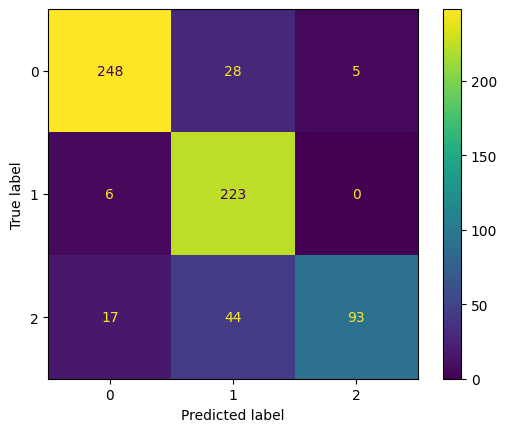

In [60]:
############# plot confusion matrix ############

from sklearn import metrics

cm = metrics.confusion_matrix(target_test, test_preds_SVC.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()